As a simple validation, I compare the CAM6 SAI 2020 temperature field to the analogous scenario in WACCM. The annual mean temperature field is decomposed into three components: 

GMST, inter-hemispheric temperature gradient and equator-pole temperature different

# Preparation

## Modules

In [1]:
import sys
import os
import warnings
import pickle

import matplotlib.patches as mpatches
import numpy as np
import cftime
import xarray as xr
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib
import cartopy
import cartopy.crs as ccrs
import pop_tools
import cmocean
import gsw
from mpl_toolkits.axes_grid1 import ImageGrid
sys.path.insert(0, "/home/dpfluger/scripts/cesm_tools/")
import cesm_data_tools
import pop_plot
import cesm_scenarios
import geo_tools
#import msf_tools

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'Nimbus Roman'
%reload_ext autoreload
%autoreload 2
# reset to standard notebook plotting after enabling animated plots
%matplotlib inline 

## Load scenarios

In [2]:
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01',
                                                        'years': np.arange(2015,2100)
                                                       }}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02','years': np.arange(2045,2100)} }

#cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)} }         
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.05',
                                                        'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06',
                                                        'years': np.arange(2086,2100)}
}

cases_sai80j = {'b.e21.BSSP585cmip6.f09_g17.feedback.09': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09',
                                                        'years': np.arange(2080,2100)},
}

cases = [cases_cnt, cases_sai20, cases_sai80, cases_sai80j]
#cases = [cases_cnt, cases_sai20, cases_sai80]
#cases_new = [cases_sai80j] # add SAI 2080 J data

scenario_names = ['Control', 'SAI 2020', 'SAI 2080', 'SAI 2080 J']
#scenario_names_new = ['SAI 2080 J']

scenarios = {name: cesm_scenarios.Scenario(name,case) for name, case in zip(scenario_names,cases)}

In [3]:
get_atm_vars = ['TREFHT']

for var in get_atm_vars:
    for name in scenarios:
        scenarios[name].get_atm_var(var)

# Load Tilmes

In [4]:
da1 = xr.open_dataset('/home/dpfluger/data/waccm_tilmes/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.003.cam.h0.TREFHT.202001-206912.nc')
da2 = xr.open_dataset('/home/dpfluger/data/waccm_tilmes/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.003.cam.h0.TREFHT.207001-210012.nc')
trefht_tilmes = xr.concat([da1.TREFHT,da2.TREFHT],dim='time')

# Temperature modes

In [5]:
fsize = 8
fsize_min = 6

fontf = {'family': 'Nimbus Roman',
        'fontsize': 8
        }

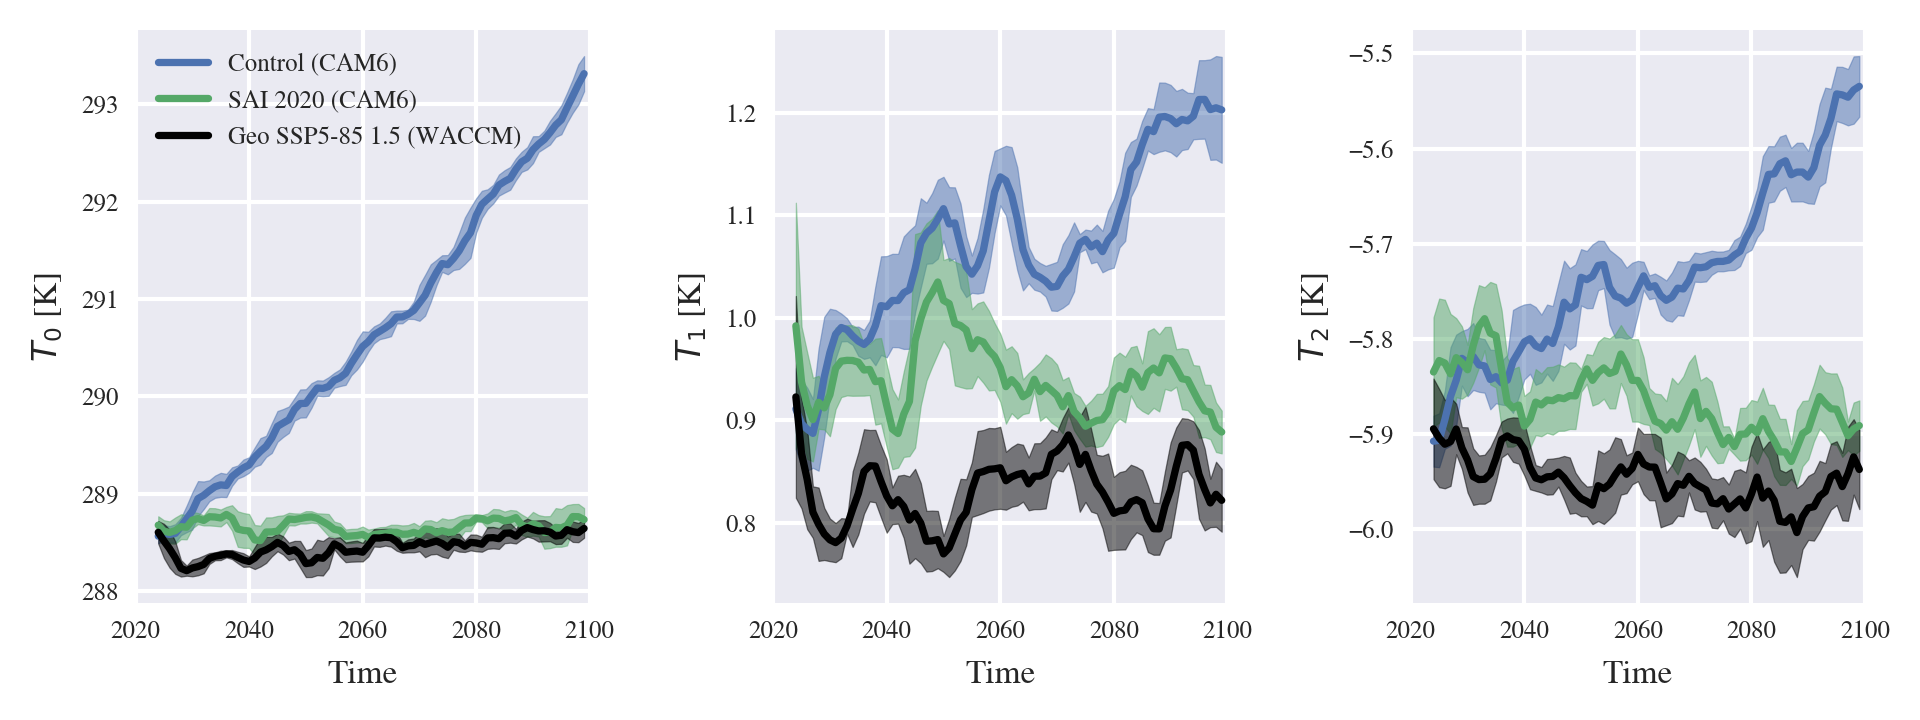

In [6]:
fig, axes = plt.subplots(ncols=3,figsize=(6.5,2.5),dpi=300)

trefht_cnt = scenarios['Control']['TREFHT'].groupby('time.year').mean(dim='time').sel(year=slice('2020','2099'))
trefht_cam6 = scenarios['SAI 2020']['TREFHT'].groupby('time.year').mean(dim='time').sel(year=slice('2020','2099'))
trefht_waccm = trefht_tilmes.groupby('time.year').mean(dim='time').sel(year=slice('2020','2099'))
colors = ['C0','C1','black']
names = ['Control (CAM6)', 'SAI 2020 (CAM6)', 'Geo SSP5-85 1.5 (WACCM)']
for n, ax, name in zip([0,1,2],axes,names):
    
    mean_cnt = geo_tools.meridional_L(trefht_cnt,n).rolling(year=5).mean()
    mean_cam6 = geo_tools.meridional_L(trefht_cam6,n).rolling(year=5).mean()
    mean_waccm = geo_tools.meridional_L(trefht_waccm,n).rolling(year=5).mean()
    means = [mean_cnt,mean_cam6,mean_waccm]

    for mean_da, color, name in zip(means,colors,names): 
        mean_da.plot(ax=ax,color=color,label=name)
    std_cnt = geo_tools.meridional_L(trefht_cnt,n).rolling(year=5).std()
    std_cam6 = geo_tools.meridional_L(trefht_cam6,n).rolling(year=5).std()
    std_waccm = geo_tools.meridional_L(trefht_waccm,n).rolling(year=5).std()
    stds = [std_cnt,std_cam6,std_waccm]

    for mean_da, std_da, color in zip(means,stds,colors):
        ax.fill_between(mean_da.year, mean_da-std_da,mean_da+std_da,color=color,alpha=0.5)
    
for ax in axes:
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlim([2020,2100])
    ax.set_xlabel('Time',fontsize=fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize_min, pad=4.0)
    
axes[0].legend(fontsize=fsize_min)
axes[0].set_ylabel(r'$T_0$ [K]',fontsize=fsize)
axes[1].set_ylabel(r'$T_1$ [K]',fontsize=fsize)
axes[2].set_ylabel(r'$T_2$ [K]',fontsize=fsize)

plt.tight_layout()

In [95]:
fig.savefig('./gfx/rev_validation_trefht.pdf',bbox_inches='tight')